# As a simple experiment, try to see if we can classify spots with colonic epithelial cells using spatial transcriptomics data

Use EPCAM expression on C.diff.C1 and predict on C.diff.B1

In [1]:
from steml.recipes import label

In [2]:
thresholds = [
    ('C.diff', 'A1', 5),
    ('C.diff', 'B1', 20),
    ('C.diff', 'C1', 20),
    ('H.pylori', 'A1', 5),
    ('H.pylori', 'B1', 3),
    ('H.pylori', 'C1', 1),
    ('H.pylori', 'D1', 0),
]

In [3]:
for slide, section, threshold in thresholds:
    label(
        feature_barcode_matrix=f'/mnt/data5/output/count/gi-infection/{slide}/{section}/outs/filtered_feature_bc_matrix',
        conditions=[[('EPCAM', False, threshold)]],
        name='epithelium',
        output_dir=f'/mnt/data5/output/tiles/gi-infection-scaled/{slide}/{section}',
    )

2022-07-15 09:33:16 - INFO - _log:27 - Logging configuration was loaded. Log messages can be found at /mnt/data5/output/tiles/gi-infection-scaled/C.diff/A1/label.log.
2022-07-15 09:33:24 - INFO - _preprocess:168 - labeled 608/710 (0.856) as epithelium at /mnt/data5/output/tiles/gi-infection-scaled/C.diff/A1
2022-07-15 09:33:24 - INFO - _preprocess:169 - (EPCAM>5)
2022-07-15 09:33:24 - INFO - _log:27 - Logging configuration was loaded. Log messages can be found at /mnt/data5/output/tiles/gi-infection-scaled/C.diff/B1/label.log.
2022-07-15 09:33:31 - INFO - _preprocess:168 - labeled 258/555 (0.465) as epithelium at /mnt/data5/output/tiles/gi-infection-scaled/C.diff/B1
2022-07-15 09:33:31 - INFO - _preprocess:169 - (EPCAM>20)
2022-07-15 09:33:31 - INFO - _log:27 - Logging configuration was loaded. Log messages can be found at /mnt/data5/output/tiles/gi-infection-scaled/C.diff/C1/label.log.
2022-07-15 09:33:51 - INFO - _preprocess:168 - labeled 445/2891 (0.154) as epithelium at /mnt/data5/

In [5]:
from steml.recipes import train

In [9]:
help(train)

Help on function train in module steml.recipes._train:

train(label: str, num_classes: int, train_csv: str, activation: str, batch_size: int, epochs: int, lr: float, loss: str, metrics: List[str], output_dir: str, num_workers: int, callback_monitor: str, cache: bool = False, shuffle_train: bool = True, augment_train: bool = True, balance_train: bool = False, val_csv: Union[str, NoneType] = None, shuffle_val: bool = True, augment_val: bool = True, balance_val: bool = False, test_csv: Union[str, NoneType] = None, patience: Union[int, NoneType] = None, lr_reduction: Union[float, NoneType] = None, lr_patience: Union[int, NoneType] = None, num_reductions: Union[int, NoneType] = None, min_delta: float = 0.0001, gpu_config: Union[Tuple[int, int], NoneType] = None, log_level: steml.defines.LogLevel = <LogLevel.INFO: 20>, skip_log_config: bool = False) -> None



In [23]:
train(
    label='epithelium',
    num_classes=2,
    train_csv='/mnt/data5/output/tiles/gi-infection-scaled/C.diff/C1/epithelium.csv',
    activation='softmax',
    batch_size=256,
    epochs=50,
    lr=0.01,
    loss='categorical_crossentropy',
    metrics=['categorical_accuracy', 'AUC'],
    output_dir='/mnt/data5/output/train/colon-epithelium',
    num_workers=4,
    callback_monitor='loss',
    cache=True,
    shuffle_train=True,
    augment_train=True,
    balance_train=False,
    test_csv='/mnt/data5/output/tiles/gi-infection-scaled/C.diff/B1/epithelium.csv',
    gpu_config=(0, -1),
)

2022-07-14 11:44:35 - INFO - _log:27 - Logging configuration was loaded. Log messages can be found at /mnt/data5/output/train/colon-epithelium/train.log.
Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv2d_40 (Conv2D)              (None, 112, 112, 64) 9472        input_3[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_2 (MaxPooling2D)  (None, 56, 56, 64)   0           conv2d_40[0][0]                  
__________________________________________________________________________________________________
conv2d_41 (Conv2D)              

In [12]:
import pandas as pd

In [24]:
train_true = pd.read_csv('/mnt/data5/output/tiles/gi-infection-scaled/C.diff/C1/epithelium.csv')['epithelium']
train_pred = pd.read_csv('/mnt/data5/output/train/colon-epithelium/train_predictions.csv')['epithelium']

test_true = pd.read_csv('/mnt/data5/output/tiles/gi-infection-scaled/C.diff/B1/epithelium.csv')['epithelium']
test_pred = pd.read_csv('/mnt/data5/output/train/colon-epithelium/test_predictions.csv')['epithelium']

In [14]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

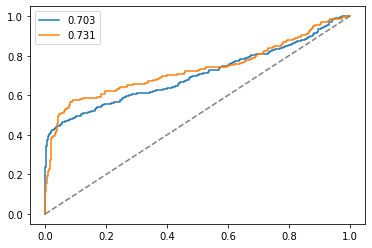

In [25]:
train_fpr, train_tpr, _ = roc_curve(train_true, train_pred)
test_fpr, test_tpr, _ = roc_curve(test_true, test_pred)
plt.plot(train_fpr, train_tpr, label=f'{auc(train_fpr, train_tpr):0.3f}')
plt.plot(test_fpr, test_tpr, label=f'{auc(test_fpr, test_tpr):0.3f}')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.legend()